In [1]:
import pandas as pd
import numpy as np
import lightgbm  as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [2]:
d=pd.read_csv('dataset.csv')
df=d

In [3]:
df.shape

(1296675, 23)

In [4]:
df['gender']=df['gender'].replace({'M':1,'F':0})

In [5]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,0,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,1,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,1,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


//Remember to comeback and use timestampp feature that you missed in version1, use hours and day of week for better offer.

In [7]:
drop_columns=['Unnamed: 0', 'trans_date_trans_time',  'first', 'last', 'street', 'city', 'state', 'zip',
       'job', 'dob', 'trans_num']
df=df.drop(columns=drop_columns)

In [8]:
df.shape

(1296675, 12)

In [9]:
df.isnull().sum().sum()

0

In [10]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0


In [11]:
df.select_dtypes(include='object')

,merchant,category
0,"fraud_Rippin, Kub and Mann",misc_net
1,"fraud_Heller, Gutmann and Zieme",grocery_pos
2,fraud_Lind-Buckridge,entertainment
3,"fraud_Kutch, Hermiston and Farrell",gas_transport
4,fraud_Keeling-Crist,misc_pos
...,...,...
1296670,fraud_Reichel Inc,entertainment
1296671,fraud_Abernathy and Sons,food_dining
1296672,fraud_Stiedemann Ltd,food_dining
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining


In [12]:
print(df['merchant'].nunique())
print(df['category'].nunique())

693
14


Here we found that category has only 14 columns while findign categorical data, we will use one hot encoding to use this data properly and making it useful for training, 
One hot-encoding converts these categorycolumn items to columns with value 0/1 so training can become easy.

In [13]:
df=pd.get_dummies(df, columns=['category'],drop_first=True)

In [14]:
df.shape

(1296675, 24)

In [15]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [16]:
df.head()

,cc_num,merchant,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2703186189652095,"fraud_Rippin, Kub and Mann",4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,False,False,False,False,False,False,False,True,False,False,False,False,False
1,630423337322,"fraud_Heller, Gutmann and Zieme",107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,False,False,False,True,False,False,False,False,False,False,False,False,False
2,38859492057661,fraud_Lind-Buckridge,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,False,True,False,False,False,False,False,False,False,False,False,False,False
4,375534208663984,fraud_Keeling-Crist,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,False,False,False,False,False,False,False,False,True,False,False,False,False


In [17]:
# print(df.groupby('merchant')['is_fraud'].count().sort_values(ascending=False).head())
print(df.groupby('merchant')['is_fraud'].mean().sort_values(ascending=False))

merchant
fraud_Kozey-Boehm                        0.025723
fraud_Herman, Treutel and Dickens        0.025385
fraud_Kerluke-Abshire                    0.022307
fraud_Brown PLC                          0.022109
fraud_Goyette Inc                        0.021616
                                           ...   
fraud_Osinski Inc                        0.000000
fraud_Hodkiewicz, Prohaska and Paucek    0.000000
fraud_Schroeder, Wolff and Hermiston     0.000000
fraud_Gulgowski LLC                      0.000000
fraud_Schroeder Group                    0.000000
Name: is_fraud, Length: 693, dtype: float64


In [18]:
merchant_fraud_rate=df.groupby('merchant')['is_fraud'].mean()

In [19]:
df['merchant_fraud_rate'] = df['merchant'].map(merchant_fraud_rate)

In [20]:
df=df.drop('merchant',axis=1)

In [21]:
df.head()

,cc_num,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,merchant_fraud_rate
0,2703186189652095,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,False,False,False,False,False,False,False,True,False,False,False,False,False,0.014207
1,630423337322,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,False,False,False,True,False,False,False,False,False,False,False,False,False,0.010787
2,38859492057661,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002111
3,3534093764340240,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,False,True,False,False,False,False,False,False,False,False,False,False,False,0.003444
4,375534208663984,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,False,False,False,False,False,False,False,False,True,False,False,False,False,0.003769


In [22]:
def haversine(lat1,lon1, lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

df['distance']=haversine(df['lat'], df['long'], df['merch_lat'],df['merch_long'])

In [23]:
df.head()

,cc_num,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,merchant_fraud_rate,distance
0,2703186189652095,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,False,False,False,False,False,False,False,True,False,False,False,False,False,0.014207,78.773821
1,630423337322,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,False,False,False,True,False,False,False,False,False,False,False,False,False,0.010787,30.216618
2,38859492057661,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002111,108.102912
3,3534093764340240,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,False,True,False,False,False,False,False,False,False,False,False,False,False,0.003444,95.685115
4,375534208663984,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,False,False,False,False,False,False,False,False,True,False,False,False,False,0.003769,77.702395


In [24]:
drp_columns=['lat','long','merch_lat','merch_long']
df=df.drop(columns=drp_columns)

In [25]:
df.shape

(1296675, 21)

In [26]:
x=df.drop('is_fraud',axis=1)
y=df['is_fraud']


Now the plotting of data for EDA and data understanding

In [27]:
count_plts=[]
for col in df.columns:
    if (df[col].nunique()<10):
        count_plts.append(col)

count_plts

['gender',
 'is_fraud',
 'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel']

In [131]:
x_train.head()

,amt,gender,city_pop,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,merchant_fraud_rate,distance
330201,6.51,0,1178,False,False,False,False,False,False,False,False,False,False,False,False,True,0.002488,61.941452
798518,20.17,0,85,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,111.406054
1260375,35.85,0,24536,False,False,False,False,True,False,False,False,False,False,False,False,False,0.008531,64.663392
412511,42.21,1,3096,False,False,True,False,False,False,False,False,False,False,False,False,False,0.002188,76.236896
344644,57.24,0,128354,False,False,False,False,False,False,True,False,False,False,False,False,False,0.002210,121.387057


In [135]:
max(x_train['merchant_fraud_rate'])

0.02572347266881029

In [28]:
# for col in count_plts:
#     sns.countplot(data=df, x=col, hue='is_fraud')
#     plt.show()

In [29]:
df.groupby('is_fraud')['amt'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


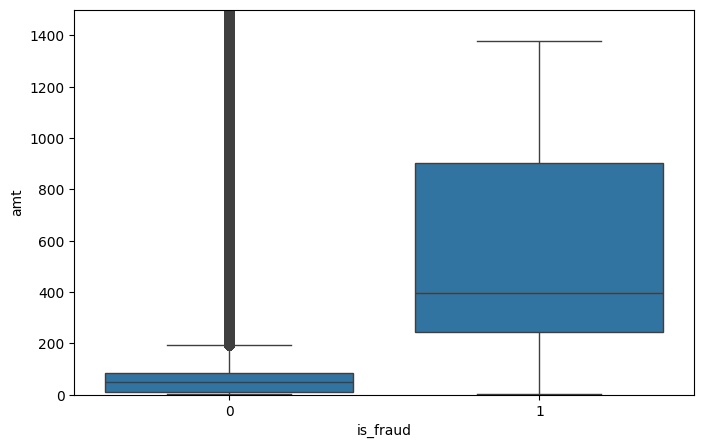

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.ylim(0, 1500)   # zoom, big outliers exist
plt.show()

In [31]:
df.groupby('is_fraud')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,76.111582,29.094814,0.022274,55.355855,78.264854,98.469116,151.868200
1,7506.0,76.266532,28.728824,0.737826,55.661753,78.004095,98.344082,144.355894


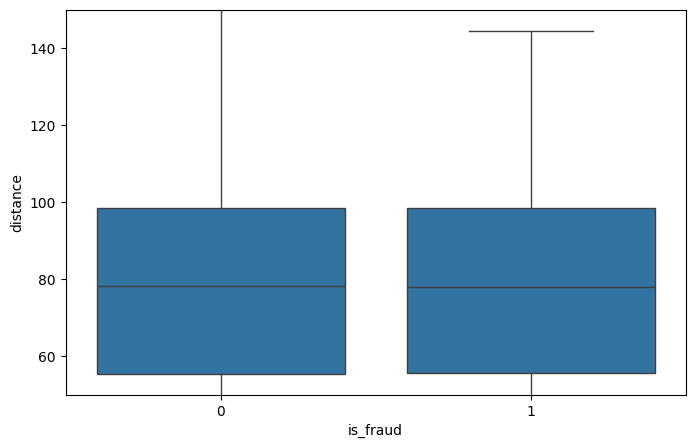

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='distance', data=df)
plt.ylim(50, 150)
plt.show()

Model preparation and trainng

In [91]:
df=df.drop( 'unix_time', axis=1)
df=df.drop('cc_num', axis=1)

In [92]:
df.head()

,amt,gender,city_pop,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,merchant_fraud_rate,distance
0,4.97,0,3495,0,False,False,False,False,False,False,False,True,False,False,False,False,False,0.014207,78.773821
1,107.23,0,149,0,False,False,False,True,False,False,False,False,False,False,False,False,False,0.010787,30.216618
2,220.11,1,4154,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0.002111,108.102912
3,45.00,1,1939,0,False,True,False,False,False,False,False,False,False,False,False,False,False,0.003444,95.685115
4,41.96,1,99,0,False,False,False,False,False,False,False,False,True,False,False,False,False,0.003769,77.702395


In [93]:
x=df.drop('is_fraud',axis=1)
y=df['is_fraud']

In [94]:
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

In [95]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

is_fraud
0    0.994229
1    0.005771
Name: proportion, dtype: float64
is_fraud
0    0.994139
1    0.005861
Name: proportion, dtype: float64


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# from xgboost import XGBclassifier

In [97]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)





In [99]:
model=LogisticRegression(max_iter=1000)
model.fit(x_train_scaled,y_train)

y_pred = model.predict(x_test_scaled)
y_pred_prob=model.predict_proba(x_test_scaled)[:,1]


In [100]:
roc_auc_score(y_test, y_pred_prob)

0.8512687162459414

In [101]:
y_pred_new = (y_pred_prob >= 0.1).astype(int)

confusion_matrix(y_test, y_pred_new)

array([[257350,    465],
       [  1212,    308]], dtype=int64)

In [102]:
y_pred_prob.max(), y_pred_prob.min()

(1.0, 1.3126492740678797e-06)

//Random forest for predictions

In [103]:
rf=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [104]:
rf.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [105]:
y_pred_rf=rf.predict(x_test)
confusion_matrix(y_test, y_pred_rf)

array([[257602,    213],
       [   536,    984]], dtype=int64)

In [106]:
roc_auc_score(y_test, y_pred_rf)

0.823271123622916

In [107]:
rf_pred_prob = rf.predict_proba(x_test)[:,1]


In [108]:
roc_auc_score(y_test, rf_pred_prob)

0.9734048894709283

In [117]:
feature_importance=pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_importance.head(18)

amt                        0.562552
distance                   0.112195
city_pop                   0.102774
merchant_fraud_rate        0.086663
category_grocery_pos       0.058385
category_gas_transport     0.022570
gender                     0.011369
category_shopping_net      0.010834
category_misc_net          0.010032
category_misc_pos          0.007470
category_travel            0.005329
category_shopping_pos      0.004693
category_home              0.001524
category_grocery_net       0.000881
category_personal_care     0.000802
category_kids_pets         0.000757
category_food_dining       0.000645
category_health_fitness    0.000525
dtype: float64

Depolyment of random forest model

In [120]:
import joblib

joblib.dump(rf, "fraud_model.pkl")

['fraud_model.pkl']